# Example 2. Using WAC-Net

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Quantitative-Microplankton-Tracker/blob/main/examples/2-example_WACNet.ipynb)

This example demonstrates how to use a pre-trained WAC-Net (Weighted average convolutional neural network) on experimental images to extract more accurate values of dry mass

**NOTE**:
- If you're using google colaboratory to run this notebook, please uncomment the code in the following cell to clone the repository.
- If you're running the notebook on your local machine, please skip this step to avoid cloing the repository in the current folder.

In [1]:
# !git clone https://github.com/softmatterlab/Quantitative-Microplankton-Tracker.git
# %cd Quantitative-Microplankton-Tracker/examples/

In [2]:
%matplotlib inline
import sys
sys.path.append("..")

## 1. Setup
Import the dependencies to run this tutorial. 

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt

## 2. Load experimental holographic image
Experimental images are located in ```sample-data``` folder

In [4]:
# Load figure 3 data

predator_sequence = np.load(
    "../data/data_figure3/predator_sequence.npy"
)

prey_sequence = np.load(
    "../data/data_figure3/prey_sequence.npy"
)

### 2.1. Visualize prey and predator planktons

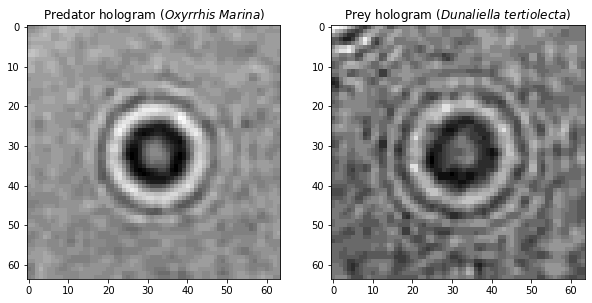

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Predator hologram ($\it{Oxyrrhis\ Marina}$)")
plt.imshow(predator_sequence[0], cmap="gray")

plt.subplot(1,2,2)
plt.title("Prey hologram ($\it{Dunaliella\ tertiolecta}$)")
plt.imshow(prey_sequence[0], cmap="gray")

## 3. Load pre-trained WAC-Net model
We define the WAC-Net model and load the weights from a pre-trained model. 

In [6]:
model = dt.models.WACNet(outputs = 2) # 2 outputs: dry mass and radius
model.load_weights("../pre-trained-models/WACNet_dry_mass.h5")

## 4. WAC-Net prediction on experimental image

### 4.1. Normalise the experimental image
Normalise and reshape the image for WAC-Net prediction

In [7]:
def Normalise(images, batch = 15):
    Normalised = []
    for i in range(len(images)):
        Normalised.append(images[i]/np.median(images[i]))
    Normalised = np.array(Normalised)-1
    proc = []
    
    #sliding window
    for i in range(len(Normalised)-batch+1):
        proc.append(Normalised[i:i+batch])
    return np.expand_dims(proc, axis = -1)

In [8]:
# Funtion to convert the predicted dry mass to real dry mass units (pico grams)
def real_dm(p, a=209.16, b=0.28, sp_ri_inc = 0.21):
    return (p*a+b)/sp_ri_inc

### 4.2. Prediction on experimental sequences
Experimental sequences are normalized with ```batch``` size of 1. ```batch``` value can be increased to generate a sliding window of the experimental sequence. The WAC-Net assigns weights to the images with in sliding windows to predict the best possible value for dry mass considering all the frames.

In [9]:
prediction_predator = model.predict(
    Normalise(
        predator_sequence,
        batch = 1
    )
)

prediction_prey = model.predict(
    Normalise(
        prey_sequence,
        batch = 1
    )
)

### 4.3. Convert values to real dry mass units

In [10]:
drymass_predator = real_dm(prediction_predator[:,0])
drymass_prey = real_dm(prediction_prey[:,0])

### 4.4. Visualize the dry mass transition in a feeding event

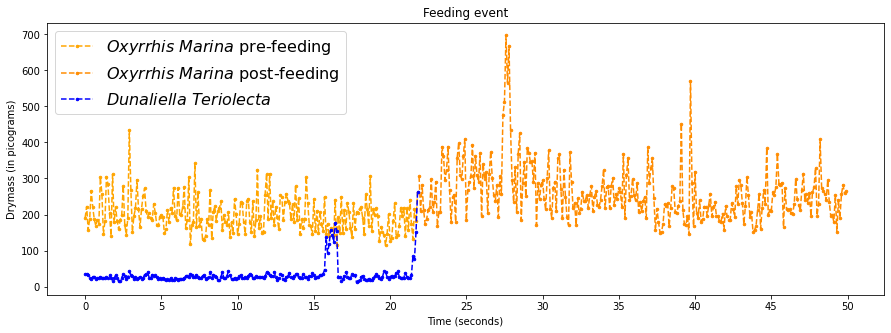

In [11]:
feeding_at = 219

fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Feeding event")
plt.plot(np.arange(0,feeding_at,1), drymass_predator[0:feeding_at], linestyle='dashed',color='orange', marker='.', label='$\it{Oxyrrhis\ Marina}$ pre-feeding', alpha = 1, markersize = '5')
plt.plot(np.arange(feeding_at,len(drymass_predator), 1),drymass_predator[feeding_at:], linestyle='dashed',color='darkorange', marker='.', label='$\it{Oxyrrhis\ Marina}$ post-feeding', alpha = 1, markersize = '5')
plt.plot(drymass_prey[:feeding_at], linestyle='dashed',color='blue', marker='.', label='$\it{Dunaliella\ Teriolecta}$', alpha=1, markersize = '5')

plt.xlabel('Time (seconds)')
plt.ylabel('Drymass (in picograms)')

xticks = np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels([int(x*(1/10)) for x in xticks])

plt.legend(prop={'size': 16})
plt.show()